<a href="https://colab.research.google.com/github/JulienChoukroun/Autonomous-car-driving/blob/main/Lane_Navigation_Steerings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![PNS](http://caillau.perso.math.cnrs.fr/logo-pns.png)
# **<center>Autonomous Car Driving Project - Lane Keeping</center>**
<center>CHOUKROUN Julien - GOURDON Jessica - SAGNES Luc</center>


---

In [ ]:
# Mount my Google Drive. It will ask for an authenticate code
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


## Imports Packages

In [ ]:
# Imports

# python standard libraries
import os
import random

# data processing
import numpy as np
import pandas as pd

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.utils import plot_model

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

In [ ]:
# Get the versions of each package to have the same ones in the Raspberry Pi of the car.

import site, pprint
pprint.pprint(site.getsitepackages())
print(cv2.__version__)
!pip list -v

['/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/lib/python3.7/dist-packages']
4.1.2
Package                       Version             Location                               Installer
----------------------------- ------------------- -------------------------------------- ---------
absl-py                       0.12.0              /usr/local/lib/python3.7/dist-packages pip      
alabaster                     0.7.12              /usr/local/lib/python3.7/dist-packages pip      
albumentations                0.1.12              /usr/local/lib/python3.7/dist-packages pip      
altair                        4.1.0               /usr/local/lib/python3.7/dist-packages pip      
appdirs                       1.4.4               /usr/local/lib/python3.7/dist-packages pip      
argon2-cffi                   20.1.0              /usr/local/lib/python3.7/dist-packages pip      
arviz                         0.11.2              /usr/local/lib/python3.7/dist-package

## Unzip the images repository

In [ ]:
!cp /content/drive/MyDrive/ProjectS8/Dataset/ImagesFinal.zip .

In [ ]:
!unzip ImagesFinal.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ImagesFinal/image_1620827973.0557075.jpg  
  inflating: ImagesFinal/image_1622129315.6081383.jpg  
  inflating: ImagesFinal/image_1621866245.0272367.jpg  
  inflating: ImagesFinal/image_1619705469.2685156.jpg  
  inflating: ImagesFinal/image_1622129062.3009708.jpg  
  inflating: ImagesFinal/image_1622132682.9301934.jpg  
  inflating: ImagesFinal/image_1619616298.9470491.jpg  
  inflating: ImagesFinal/image_1619702762.0619683.jpg  
  inflating: ImagesFinal/image_1622129624.8873906.jpg  
  inflating: ImagesFinal/image_1622133153.3620222.jpg  
  inflating: ImagesFinal/image_1622129050.607908.jpg  
  inflating: ImagesFinal/image_1619703131.6727042.jpg  
  inflating: ImagesFinal/image_1622129261.196269.jpg  
  inflating: ImagesFinal/image_1621866731.7765765.jpg  
  inflating: ImagesFinal/image_1619703070.7677124.jpg  
  inflating: ImagesFinal/image_1619703129.1737707.jpg  
  inflating: ImagesFinal/ima

## Initialize the data

In [ ]:
# Transform our csv into dataframe
columns = ['Image', 'Speed', 'Steering']
data = pd.read_csv("/content/drive/MyDrive/ProjectS8/Dataset/datasetFinal.csv",sep=';', names = columns)
print('Total Images Imported',data.shape[0])
print(data.head())

Total Images Imported 138253
                      Image  Speed Steering
0  image_1619615992.0669918     22      1,8
1   image_1619615992.098413     22      1,8
2   image_1619615992.131889     22      1,8
3  image_1619615992.1668043     22      1,8
4  image_1619615992.1986744     22      1,8


In [ ]:
# Replace comma with dot for the steering angle. For example: '1,8' becomes '1.8'
size = len(data['Steering'])
for i in range(size):
  data['Steering'][i] = data['Steering'][i].replace(',', '.')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Visualize the data

In [ ]:
# Transform string into float
data['Steering'] = data['Steering'].astype(float)

In [ ]:
# Look at the distribution of steering angle
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['Steering'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(data['Steering'], bins=num_of_bins, width=1, color='blue')

(array([  264.,   159.,   202.,   169.,   199.,   497.,   716.,  1319.,
         2546.,  4419.,  6303.,  9772., 13812., 15463., 11870., 10856.,
        10313., 11861., 10261.,  8259.,  5083.,  3566.,  2438.,  2297.,
         5609.]),
 array([-45.   , -41.418, -37.836, -34.254, -30.672, -27.09 , -23.508,
        -19.926, -16.344, -12.762,  -9.18 ,  -5.598,  -2.016,   1.566,
          5.148,   8.73 ,  12.312,  15.894,  19.476,  23.058,  26.64 ,
         30.222,  33.804,  37.386,  40.968,  44.55 ]),
 <a list of 25 Patch objects>)

Notice that the above diagram contains angeles mostly greater than -20. This makes sense, because in our training data, the car was mostly turning right. This is going to fine, because we will balance the data by randomly flip the image, and the steering angle in the image generator process.

(array([ 7381., 12034., 12967., 14320., 15950., 10669.,  9238.,  8178.,
         7869.,  6765.,  6082.,  4723.,  4019.,  4131.,  3091.,  2558.,
         1861.,  1476.,  1496.,   872.,   525.,   657.,   315.,   368.,
          708.]),
 array([ 1.  ,  4.92,  8.84, 12.76, 16.68, 20.6 , 24.52, 28.44, 32.36,
        36.28, 40.2 , 44.12, 48.04, 51.96, 55.88, 59.8 , 63.72, 67.64,
        71.56, 75.48, 79.4 , 83.32, 87.24, 91.16, 95.08, 99.  ]),
 <a list of 25 Patch objects>)

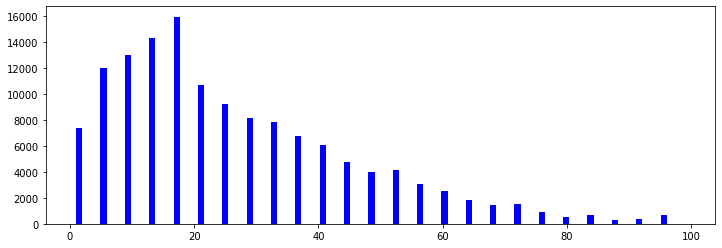

In [ ]:
# Look at the distribution of speed
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['Speed'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(data['Speed'], bins=num_of_bins, width=1, color='blue')

Notice that the above diagram contains speeds mostly lesser than 50. So we will keep our speeds up to 50 and we will put all the speeds above 50 to 50.

##Prepare for processing

In [ ]:
# Convert the dataframe into lists. We created 3 differents lists: 
# the images paths list, the speeds list and the steering angles list
def loadData(path, data):
  imagesPath = []
  speed = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    imagesPath.append(path + "/" + indexed_data[0] + ".jpg")
    speed.append(float(indexed_data[1]))
    steering.append(float(indexed_data[2]))
  imagesPath = np.asarray(imagesPath)
  speed = np.asarray(speed)
  steering = np.asarray(steering)
  return imagesPath, speed, steering

In [ ]:
imagesPath, speeds, steerings = loadData("/content/ImagesFinal",data)

print(imagesPath)
print(speeds)
print(steerings)

['/content/ImagesFinal/image_1619615992.0669918.jpg'
 '/content/ImagesFinal/image_1619615992.098413.jpg'
 '/content/ImagesFinal/image_1619615992.131889.jpg' ...
 '/content/ImagesFinal/image_1622135331.903165.jpg'
 '/content/ImagesFinal/image_1622135331.9364252.jpg'
 '/content/ImagesFinal/image_1622135331.9712825.jpg']
[22. 22. 22. ... 67. 67. 67.]
[1.8  1.8  1.8  ... 2.25 2.25 2.25]


In [ ]:
print(len(imagesPath))
print(len(speeds))
print(len(steerings))

138253
138253
138253


We normalize our steerings values between -1 and 1.

In [ ]:
steerings = steerings/45
steerings = steerings.astype('float32')
print(min(steerings))
print(max(steerings))

-1.0
0.99


We put all the speeds above 50 to 50 to keep only our speeds up to 50.

In [ ]:
speeds[speeds>50]=50
print(max(speeds))

50.0


In [ ]:
# Look at the distribution of speed
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(speeds, num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(speeds, bins=num_of_bins, width=1, color='blue')

(array([ 3248.,  4133.,  5645.,  6389.,  6373.,  6594.,  7315.,  7005.,
         8156.,  7794.,  5921.,  4748.,  4670.,  4568.,  4038.,  4140.,
         3982.,  3887.,  3415.,  3350.,  3041.,  3041.,  2290.,  2433.,
        22077.]),
 array([ 1.  ,  2.96,  4.92,  6.88,  8.84, 10.8 , 12.76, 14.72, 16.68,
        18.64, 20.6 , 22.56, 24.52, 26.48, 28.44, 30.4 , 32.36, 34.32,
        36.28, 38.24, 40.2 , 42.16, 44.12, 46.08, 48.04, 50.  ]),
 <a list of 25 Patch objects>)

We normalize our speeds values between -1 and 1.

In [ ]:
speeds = speeds/25
speeds = speeds-1
speeds = speeds.astype('float32')
print(min(speeds))
print(max(speeds))

-0.96
1.0


We create a vector containing the speeds and the steering angles. It is used to predict both speed and steering angle (but not used for this project since we only focus on steering angle).

In [ ]:
speedsSteerings = np.array([speeds, steerings])
speedsSteerings = np.transpose(speedsSteerings)
print(speedsSteerings)

[[-0.12  0.04]
 [-0.12  0.04]
 [-0.12  0.04]
 ...
 [ 1.    0.05]
 [ 1.    0.05]
 [ 1.    0.05]]


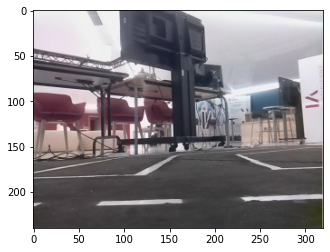

In [ ]:
imageTest = plt.imread(imagesPath[0])
plt.imshow(imageTest)
plt.show()

In [ ]:
print(imageTest.shape)

(240, 320, 3)


## Split for training and validation

In [ ]:
# We will split the training data into training/validation sets with a 80/20 split with sklearn’s train_test_split method.
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings, 
                                              test_size=0.2, random_state=10)

print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))

Total Training Images:  110602
Total Validation Images:  27651


## Augment data

Since we only have a few hundred images, to train a deep network, we need a lot more images. Instead of running our car, let's try to augment our data. There are a couple of ways to do that:
- Zoom: crop out a smaller image from the center
- Pan: crop out a smaller image from left or right side
- adjust brightness of the image
- flip the image horizontally, i.e do a left to right flip, and change the steering angle correspondingly
- introduce an Gaussian blur

We can combine the above augmentation techniques to generate 100s times of the training images, with just a few hundred real images.

By randomly applying any or all of these 5 operations on the original images, we can generate a lot more training data from our original images, which makes our final trained model much more robust.

Text(0.5, 1.0, 'zoomed')

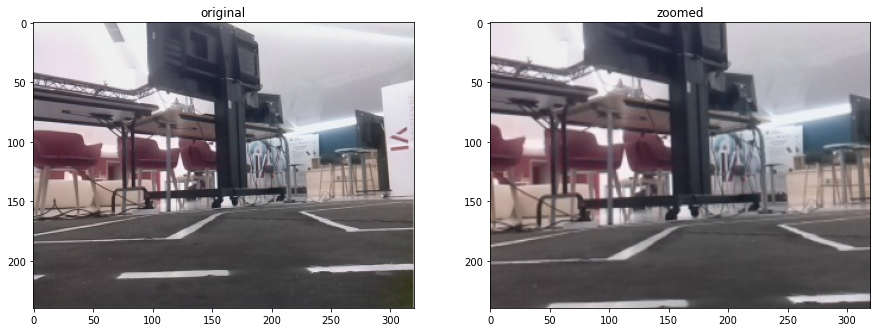

In [ ]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(imagesPath[0])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("original")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")

Text(0.5, 1.0, 'panned')

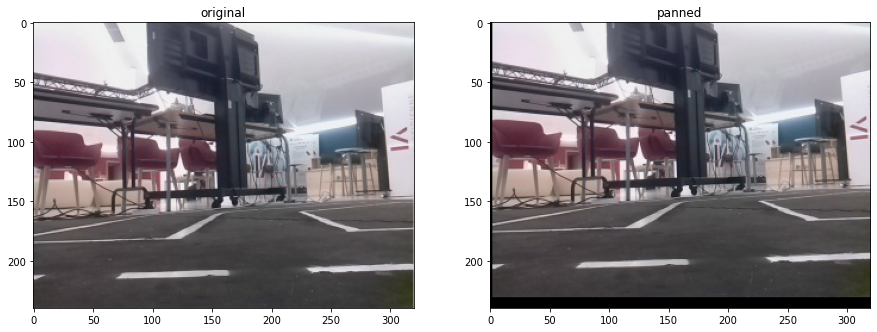

In [ ]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(imagesPath[0])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("original")
axes[1].imshow(image_pan)
axes[1].set_title("panned")

Text(0.5, 1.0, 'brightness adjusted')

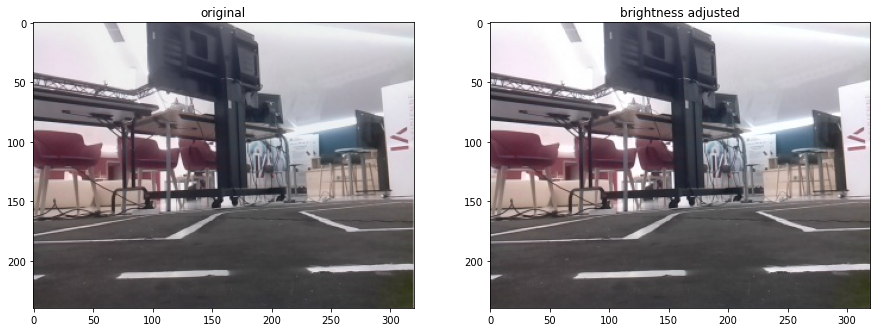

In [ ]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(imagesPath[0])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("original")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Text(0.5, 1.0, 'blurred')

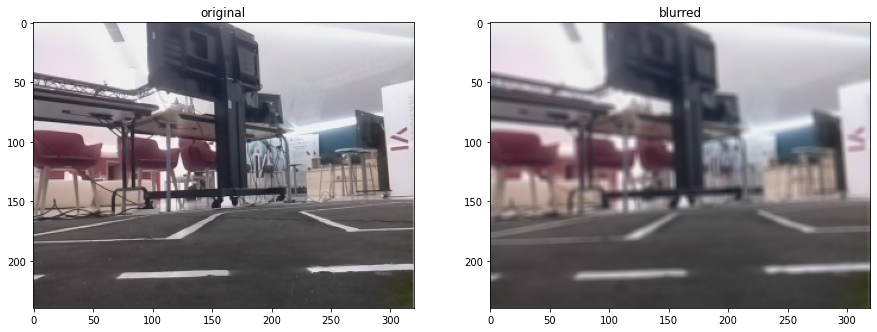

In [ ]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(imagesPath[0])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("original")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Text(0.5, 1.0, 'flipped, angle=0.04')

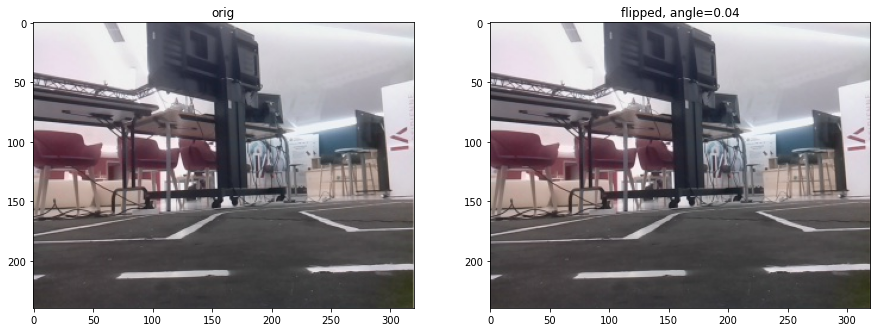

In [ ]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle = - steering_angle
   
    return image, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(imagesPath[0])
image_flip, steering_angle = random_flip(image_orig, steerings[0])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)

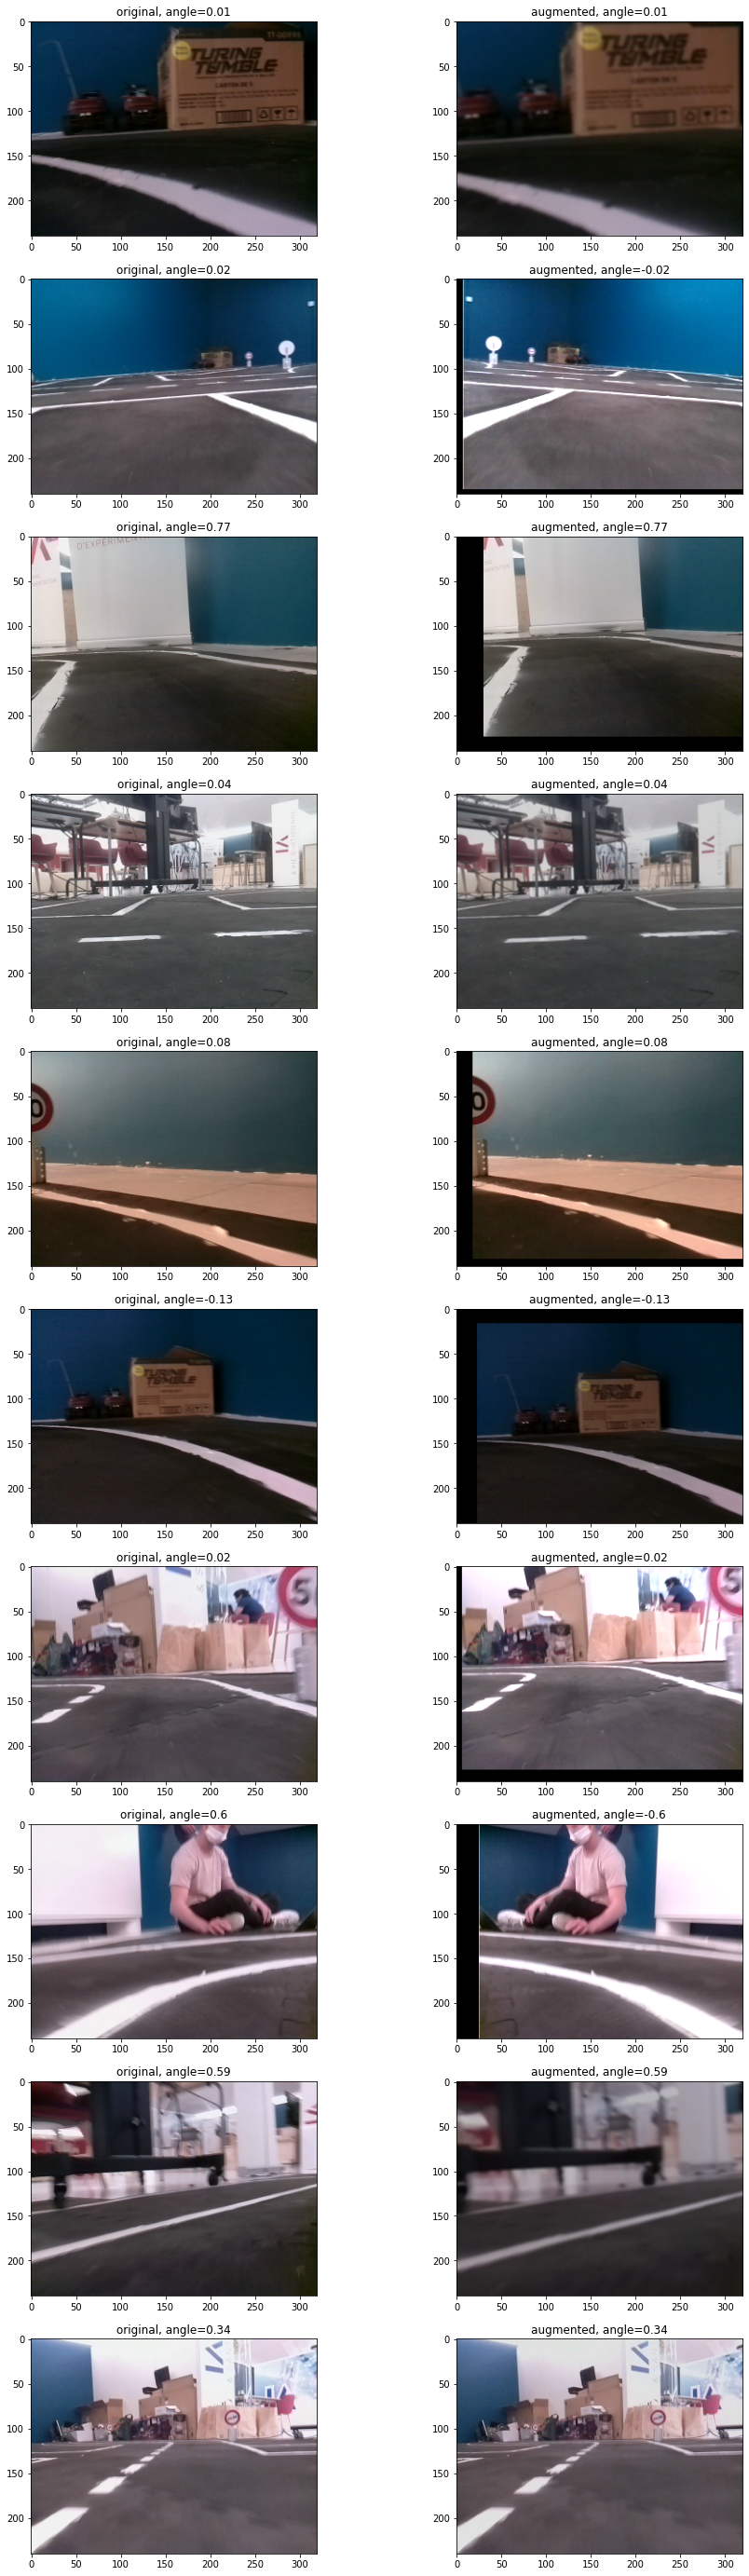

In [ ]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(imagesPath) - 1)
    image_path = imagesPath[rand_index]
    steering_angle_orig = steerings[rand_index]
    
    image_orig = my_imread(image_path)
    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)

## Preprocess

The top half of the image is not relevant to predicting the steering angle, so we will just crop it out. Secondly, we divide our pixels value by 255 to normalize them.


(120, 320, 3)


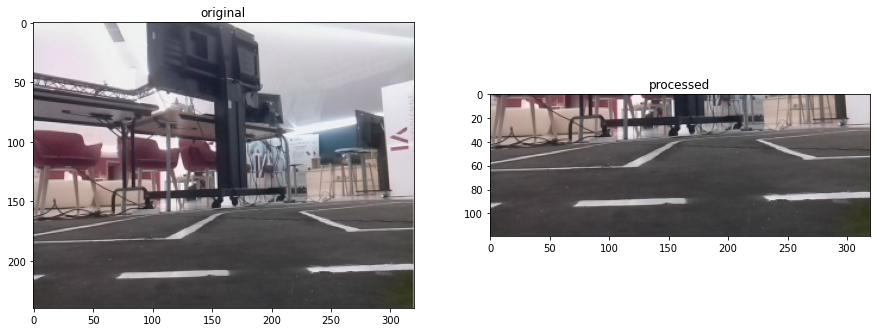

In [ ]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = image / 255 # normalizing the image
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(imagesPath[0])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("original")
axes[1].imshow(image_processed)
axes[1].set_title("processed")
print(image_processed.shape)

## Create model

**Transfer learning**

Instead training all the Nvidia model we will use transfer learning.

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. 
Transfer learning is an optimization that allows rapid progress or improved performance when modeling the second task.
Hence, it will help us a lot to overcome the lack of images.

In [ ]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input

from keras.applications.inception_v3 import InceptionV3

**VGG model**

In [ ]:
# Load VGG model and weights
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(120,320,3)) # include_top=False is to not keep the top layer

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Architecture of the VGG16 model
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 320, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 160, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 160, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 160, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 80, 128)       0     

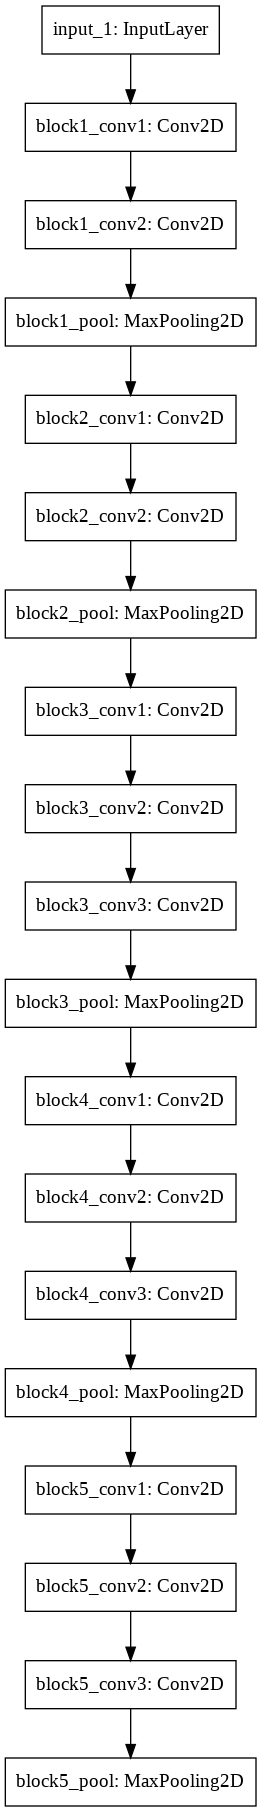

In [ ]:
# Plot the graph of the VGG16 model
plot_model(vgg_model, to_file='VGG_graph.png')

**Freeze the layer**

It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. VGG16 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [ ]:
for layer in vgg_model.layers:
  layer.trainable = False

Dense: Fully connected layer and the most common type of layer used on multi-layer perceptron models. Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer.

In [ ]:
# We add to the VGG model our finals layers from the Nvidia model
# elu=Expenential Linear Unit, similar to leaky Relu

x = Flatten()(vgg_model.output)
#dense1 = Dense(100, activation='elu')(x)
#dense2 = Dense(50, activation='elu')(dense1)
dense3 = Dense(10, activation='elu')(x)
output = Dense(1, activation='tanh')(dense3)

In [ ]:
model = Model(inputs=vgg_model.input, outputs=output)

In [ ]:
# Architecture of our final model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 320, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 160, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 160, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 160, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 80, 128)       0     

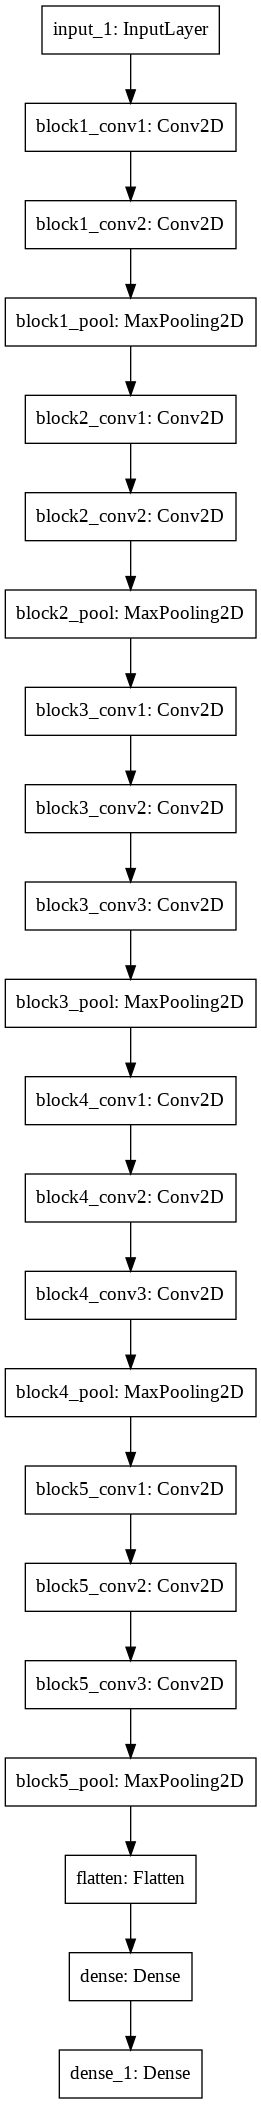

In [ ]:
# Plot the graph of our final model
plot_model(model, to_file='Model_graph.png')

In [ ]:
# Check the trainable status of the individual layers
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7efd067e3690> False
<keras.layers.convolutional.Conv2D object at 0x7efd070df7d0> False
<keras.layers.convolutional.Conv2D object at 0x7efd06d06a10> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd069b28d0> False
<keras.layers.convolutional.Conv2D object at 0x7efd065c1050> False
<keras.layers.convolutional.Conv2D object at 0x7efd06cd9750> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd06425690> False
<keras.layers.convolutional.Conv2D object at 0x7efd0612a950> False
<keras.layers.convolutional.Conv2D object at 0x7efd05fd5350> False
<keras.layers.convolutional.Conv2D object at 0x7efd065abe90> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd05c47190> False
<keras.layers.convolutional.Conv2D object at 0x7efd073250d0> False
<keras.layers.convolutional.Conv2D object at 0x7efd05c92610> False
<keras.layers.convolutional.Conv2D object at 0x7efd06d06910> False
<keras.layers.pooling.MaxPooling2D object at 0x7efd06d06e50>

**Model compilation**

Once we have defined our model, it needs to be compiled.
This creates the efficient structures used by the underlying backend in order to efficiently execute our model during training.
We compile our model using the compile() function and it accepts two important attributes:
- Model optimizer.
- Loss function.

The optimizer is the search technique used to update weights in our model.
Some popular gradient descent optimizers: 
- SGD (stochastic gradient descent with support of momentum)
- RMSprop (adaptive learning rate optimization method proposed by Geoffrey Hinton)
- Adam (Adaptive Moment Estimation that also uses adaptive learning rates)

The loss function, also called the objective function is the evaluation of the model used by the optimizer to navigate the weight space. This function is used to compute the error as the difference between the actual output and the predicted output.
Some common examples include:
- mse: for mean squared error
- binary_crossentropy: for binary logarithmic loss (logloss)
- categorical_crossentropy: for multi-class logarithmic loss (logloss)

Since this is a regression problem not classification problem, we use MSE (Mean Squared Error) as loss function

In [ ]:
optimizer = Adam(learning_rate=1e-3) # lr is learning rate
model.compile(loss='mse', optimizer=optimizer)

**Inception Model**

In [ ]:
# Load ResNet model and weights
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(120,320,3))

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
# Architecture of the InceptionV3 model
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 59, 159, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 59, 159, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 59, 159, 32)  0           batch_normalization[0][0]        
_______________________________________________________________________________________

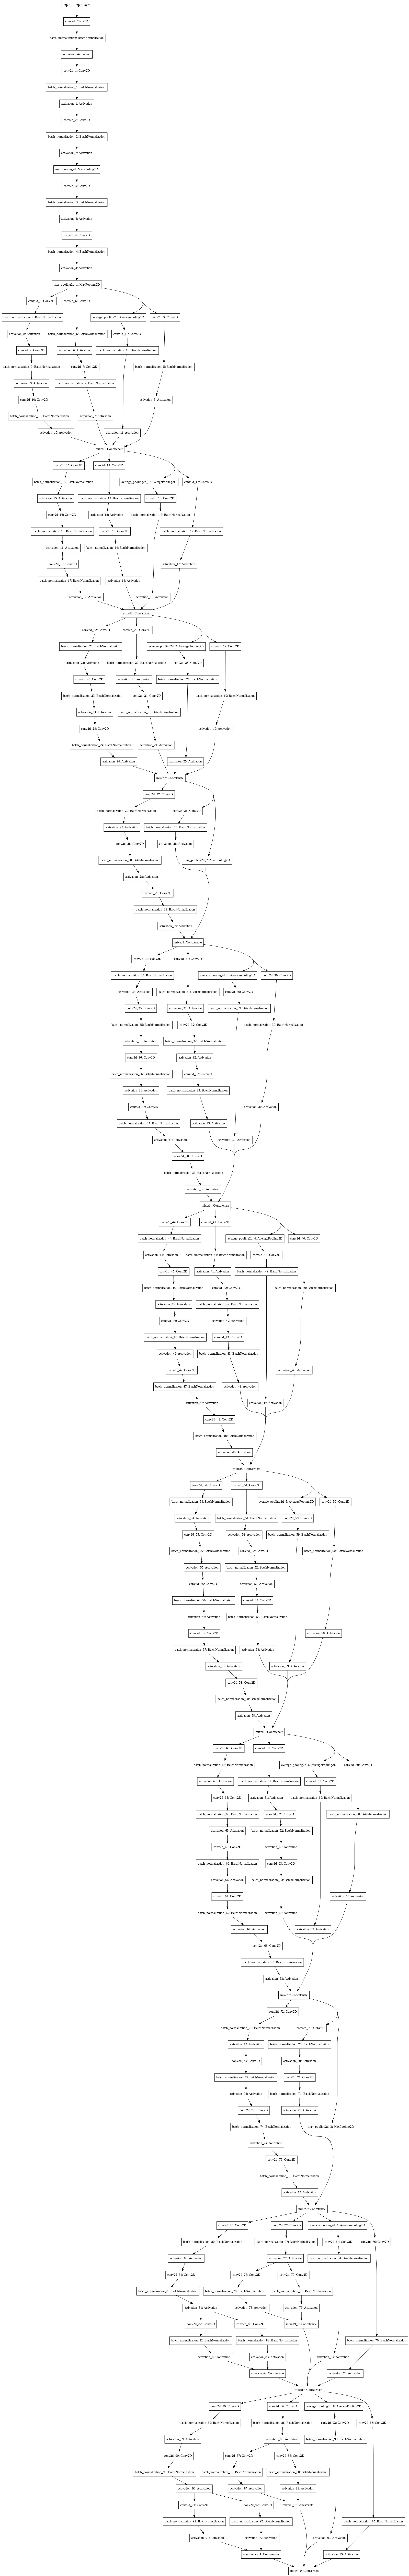

In [ ]:
# Plot the graph of the InceptionV3 model
plot_model(inception_model, to_file='Inception_graph.png')

In [ ]:
for layer in inception_model.layers:
  layer.trainable = False

In [ ]:
# We add to the VGG model our finals layers from the Nvidia model
# elu=Expenential Linear Unit, similar to leaky Relu

x = Flatten()(inception_model.output)
#dense1 = Dense(100, activation='elu')(x)
#dense2 = Dense(50, activation='elu')(dense1)
dense3 = Dense(10, activation='elu')(x)
output = Dense(1, activation='tanh')(dense3)

In [ ]:
model2 = Model(inputs=inception_model.input, outputs=output)

In [ ]:
# Architecture of our final model
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 59, 159, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 59, 159, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 59, 159, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

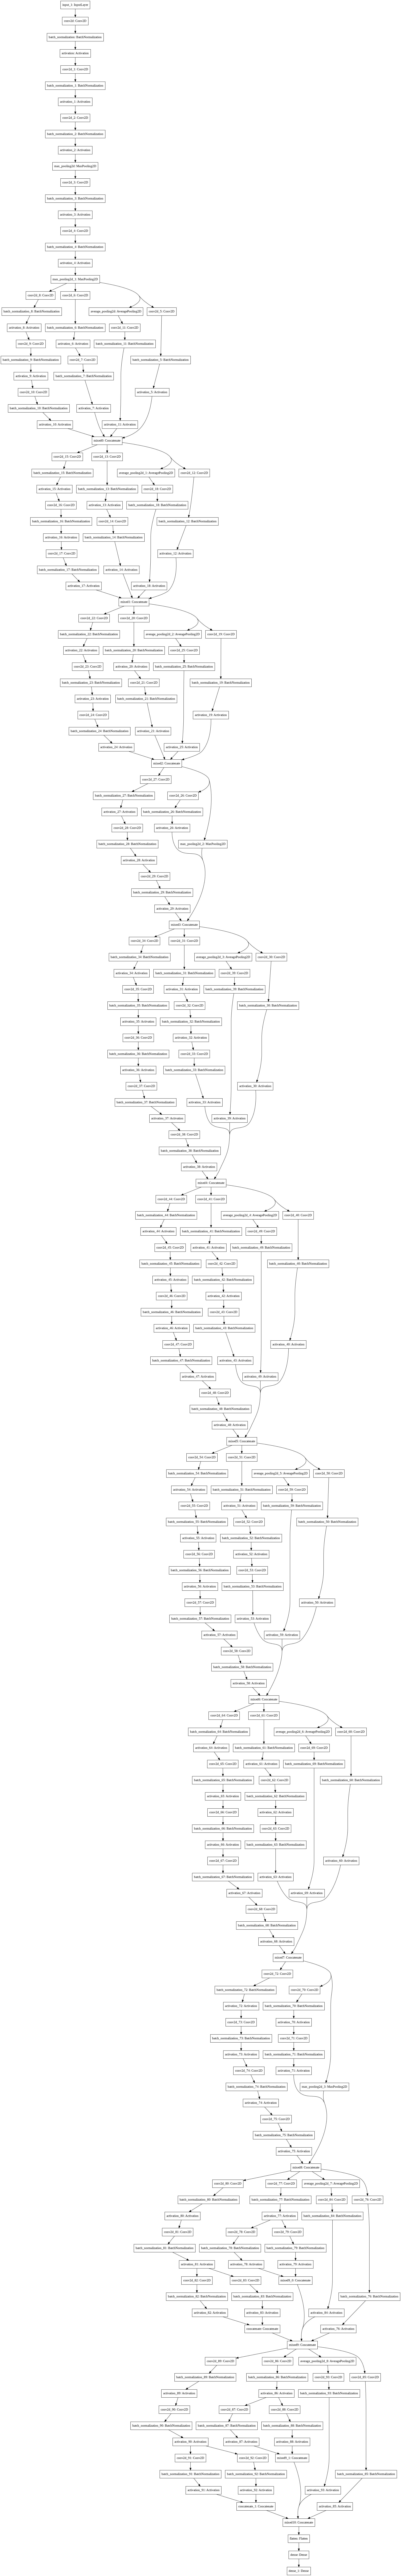

In [ ]:
# Plot the graph of our final model
plot_model(model2, to_file='Model_graph.png')

In [ ]:
# Check the trainable status of the individual layers
for layer in model2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fafa099f510> False
<keras.layers.convolutional.Conv2D object at 0x7fafa0af68d0> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7fafa0b1a290> False
<keras.layers.core.Activation object at 0x7fafa0926950> False
<keras.layers.convolutional.Conv2D object at 0x7fafa068dd10> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7faf9fcd29d0> False
<keras.layers.core.Activation object at 0x7faf9fd5cbd0> False
<keras.layers.convolutional.Conv2D object at 0x7fafa1248890> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7fafa052cfd0> False
<keras.layers.core.Activation object at 0x7fafa0f90b10> False
<keras.layers.pooling.MaxPooling2D object at 0x7faf9fd8dcd0> False
<keras.layers.convolutional.Conv2D object at 0x7fafa0520210> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7fafa0b00410> False
<keras.layers.core.Activation object at 0x7fafa0520690> False
<keras.layers.convol

In [ ]:
optimizer = Adam(learning_rate=1e-3) # lr is learning rate
model2.compile(loss='mse', optimizer=optimizer)

## Training

Now that both the data and model are ready, we will start to train the data.

For those who have used Keras to train deep-learning models, we usually use the model.fit() command. But notice that today we used model.fit_generator() command. This is because we are not using a static set of training data, our training data is generated dynamically from our original 138 253 images via image augmentation discussed earlier. For this to work, we need to create a helper function that does the augmentation and then return a new batch of training data to model.fit_generator()on each iteration.

In [ ]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

Some examples of our train and val set.

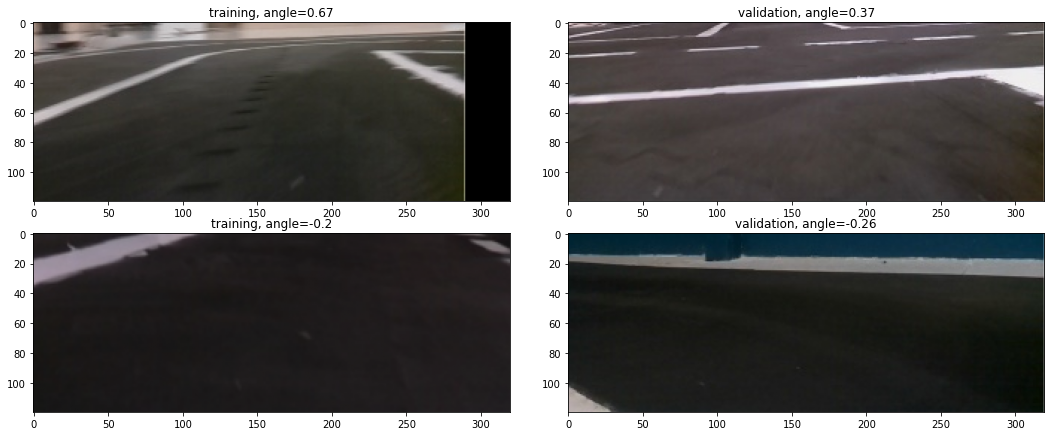

In [ ]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(xTrain, yTrain, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(xVal, yVal, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

**Model training**

The model is trained on NumPy arrays using the fit() function.

Epochs is the number of times that the model is exposed to the training dataset.

Batch_size is the number of samples that will be propagated through the network.

The fit function also allows for some basic evaluation of the model during training. We can provide a validation_data tuple of (x, y) of data to evaluate.

Fitting the model returns a history object with details and metrics calculated for the model each epoch. This can be used for graphing model performance.

In [ ]:
history = model.fit_generator(image_data_generator( xTrain, yTrain, batch_size=32, is_training=True),
                              steps_per_epoch=300,
                              epochs=50,
                              validation_data = image_data_generator( xVal, yVal, batch_size=32, is_training=False),
                              validation_steps=200,
                              verbose=1)

In [ ]:
# Save the model
model_json = model2.to_json()
with open("/content/drive/MyDrive/ProjectS8/Dataset/ModelFinal/model.json", "w") as json_file:
    json_file.write(model_json)
model2.save_weights("/content/drive/MyDrive/ProjectS8/Dataset/ModelFinal/model_weights.h5")
print("Saved model to disk")

Saved model to disk


Now it is time to see how well the training went. First thing is to plot the loss function of both training and validation sets.

In [ ]:
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [ ]:
from keras.models import model_from_json

# load json and create model
json_file = open("/content/drive/MyDrive/ProjectS8/Dataset/ModelFinalVGG/model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/ProjectS8/Dataset/ModelFinalVGG/model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# Convert the model into tensorflow lite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the model
with open('/content/drive/MyDrive/ProjectS8/Dataset/ModelFinalVGG/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpo2tlyzwx/assets


## Testing

We will test our neural network with some images from the training.

The real angle is: -9.449999704957008
The predicted angle is: -8.267877772450447


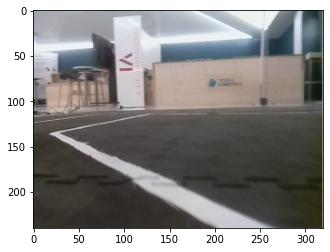

In [ ]:
print("The real angle is:", steerings[1000]*45)
imageTest1 = plt.imread(imagesPath[1000])
img1 = imageTest1
img1 = img_preprocess(img1) # Preprocess the image

img1 = np.reshape(img1,(-1,120,320,3)) # Reshape the image to put it in the neural nework
prediction1 = loaded_model.predict(img1)
#print(prediction1)

print("The predicted angle is:", prediction1[0][0]*45)

plt.imshow(imageTest1)
plt.show()

The real angle is: 10.350000187754631
The predicted angle is: 12.555685937404633


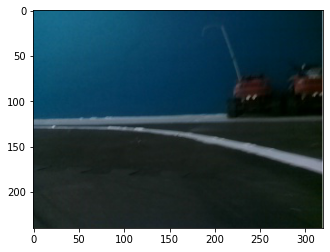

In [ ]:
print("The real angle is:", steerings[10000]*45)
imageTest2 = plt.imread(imagesPath[10000])
img2 = imageTest2
img2 = img_preprocess(img2)

img2 = np.reshape(img2,(-1,120,320,3))
prediction2 = loaded_model.predict(img2)
#print(prediction2)

print("The predicted angle is:", prediction2[0][0]*45)

plt.imshow(imageTest2)
plt.show()

The real angle is: 11.25
The predicted angle is: 16.66200578212738


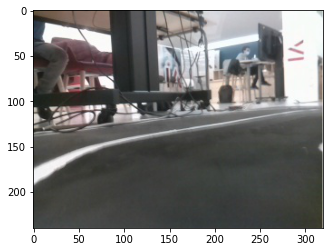

In [ ]:
print("The real angle is:", steerings[20000]*45)
imageTest3 = plt.imread(imagesPath[20000])
img3 = imageTest3
img3 = img_preprocess(img3)

img3 = np.reshape(img3,(-1,120,320,3))
prediction3 = loaded_model.predict(img3)
#print(prediction3)

print("The predicted angle is:", prediction3[0][0]*45)

plt.imshow(imageTest3)
plt.show()

We can see that our predictions are closed to the real values. So, we can say that we have a good network and a good training.